In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.functional import F

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4388595.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 127755.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1239730.10it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2804435.27it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([4, 1, 28, 28])


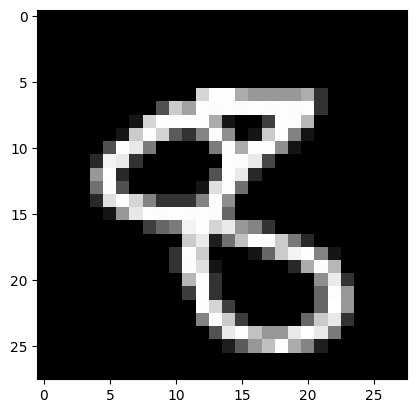

tensor(8)


In [ ]:
for images, labels in train_loader:
    print(images.shape)
    plt.imshow(images[0].squeeze(), cmap='gray')
    plt.show()
    print(labels[0])
    break

In [ ]:
labels[0]

tensor(8)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
d_noise = 100
d_hidden_1 = 256
d_hidden_2 = 256
image_dim = 28*28
batch_size = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(d_noise, 256, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), d_noise, 1, 1)  # 입력 잡음 벡터를 (batch_size, d_noise, 1, 1) 형태로 변환
        x = self.generator(x)
        return x

    def forward(self, x):
        x = self.generator(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 10),
            nn.Softmax()
        ).to(device)

    def forward(self, x):
        x = self.discriminator(x)
        return x

In [ ]:
classes = ('zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine')

disc = Discriminator().to(device)
gen = Generator().to(device)

lr = 3e-4
num_epochs = 50

opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
#criterion = nn.BCELoss()

criterion = nn.CrossEntropyLoss()

step = 0

In [ ]:
embeddings = nn.Embedding(num_embeddings=len(classes),
                               embedding_dim=100,
                               padding_idx=1)

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
    for batch_idx, (image, label) in enumerate(train_loader):
        #imgae -> (4,1,28,28)
        batch_size = image.shape[0]
        image = image.view(batch_size, 1, -1).to(device) #(4,1,784)
        label_onehot = F.one_hot(label, num_classes=len(classes)).to(device) #(4,10)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        label_embedding = embeddings(label).view(batch_size, d_noise, 1, 1).to(device) #(4,100)
        fake = gen(label_embedding) #임베딩으로 이미지 생성 #(4,3,32,32)

        disc_real = disc(image.view(4, -1)) # (4, 10)

        label_onehot = label_onehot.float()

        lossD_real = criterion(disc_real, label_onehot)


        disc.zero_grad()
        lossD_real.backward(retain_graph=True)
        opt_disc.step()


        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] lossD_real: {lossD_real:.4f}"
            )


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [0/50] lossD_real: 2.3082
Epoch [1/50] lossD_real: 1.4718
Epoch [2/50] lossD_real: 1.4612
Epoch [3/50] lossD_real: 1.7111
Epoch [4/50] lossD_real: 1.4612
Epoch [5/50] lossD_real: 1.4639
Epoch [6/50] lossD_real: 1.4612
Epoch [7/50] lossD_real: 1.4612
Epoch [8/50] lossD_real: 1.4612
Epoch [9/50] lossD_real: 1.4612
Epoch [10/50] lossD_real: 1.4612
Epoch [11/50] lossD_real: 1.4612
Epoch [12/50] lossD_real: 1.4612
Epoch [13/50] lossD_real: 1.9612
Epoch [14/50] lossD_real: 1.4612
Epoch [15/50] lossD_real: 1.7112
Epoch [16/50] lossD_real: 1.4612
Epoch [17/50] lossD_real: 1.4612
Epoch [18/50] lossD_real: 1.4612
Epoch [19/50] lossD_real: 1.4612
Epoch [20/50] lossD_real: 1.4612
Epoch [21/50] lossD_real: 1.4612
Epoch [22/50] lossD_real: 1.4944
Epoch [23/50] lossD_real: 1.4612
Epoch [24/50] lossD_real: 1.7112
Epoch [25/50] lossD_real: 1.4612
Epoch [26/50] lossD_real: 1.4612
Epoch [27/50] lossD_real: 1.4612
Epoch [28/50] lossD_real: 1.4612
Epoch [29/50] lossD_real: 1.4612
Epoch [30/50] lossD_

In [ ]:
fake_list = []
real_list = []

for epoch in range(num_epochs):
    for batch_idx, (image, label) in enumerate(train_loader):
        #imgae -> (4,1,28,28)
        batch_size = image.shape[0]
        image = image.view(batch_size, 1, -1).to(device) #(4,1,784)
        label_onehot = F.one_hot(label, num_classes=len(classes)).to(device) #(4,10)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        label_embedding = embeddings(label).view(batch_size, d_noise, 1, 1).to(device) #(4,100)
        fake = gen(label_embedding) #임베딩으로 이미지 생성 #(4,3,32,32)
        label_onehot = label_onehot.float()
        """
        disc_real = disc(image.view(4, -1)) # (4, 10)

        label_onehot = label_onehot.float()

        lossD_real = criterion(disc_real, label_onehot)

        disc_fake = disc(fake.view(4, 28*28)) # (4, 10) => (40,)
        lossD_fake = criterion(disc_fake, 1-label_onehot) / 10

        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        """
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake.view(batch_size, -1))
        lossG = criterion(output, label_onehot)
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                #fake = gen(fake).reshape(-1, 3, 32, 32)
                data = image.reshape(-1, 1, 28, 28)

                fake_list.append(fake)
                real_list.append(data)
                step += 1

Epoch [0/50] loss G: 2.3800
Epoch [1/50] loss G: 1.9612
Epoch [2/50] loss G: 2.2112
Epoch [3/50] loss G: 1.9612
Epoch [4/50] loss G: 2.2112
Epoch [5/50] loss G: 1.9612
Epoch [6/50] loss G: 1.9612
Epoch [7/50] loss G: 2.4612
Epoch [8/50] loss G: 1.7112
Epoch [9/50] loss G: 1.9612
Epoch [10/50] loss G: 2.2112
Epoch [11/50] loss G: 1.9612
Epoch [12/50] loss G: 1.7112
Epoch [13/50] loss G: 2.2112
Epoch [14/50] loss G: 1.4612
Epoch [15/50] loss G: 1.9612
Epoch [16/50] loss G: 1.9612
Epoch [17/50] loss G: 1.7112
Epoch [18/50] loss G: 1.9612
Epoch [19/50] loss G: 2.2112
Epoch [20/50] loss G: 1.7112
Epoch [21/50] loss G: 1.9612
Epoch [22/50] loss G: 2.2112
Epoch [23/50] loss G: 1.7112
Epoch [24/50] loss G: 1.9612
Epoch [25/50] loss G: 2.4612
Epoch [26/50] loss G: 1.7112
Epoch [27/50] loss G: 1.9612
Epoch [28/50] loss G: 1.7112
Epoch [29/50] loss G: 1.7112
Epoch [30/50] loss G: 1.9612
Epoch [31/50] loss G: 2.2112
Epoch [32/50] loss G: 1.9612
Epoch [33/50] loss G: 1.7112
Epoch [34/50] loss G: 1.

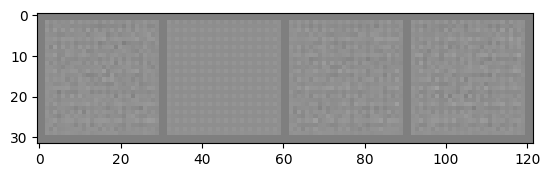

eight two   nine  six  


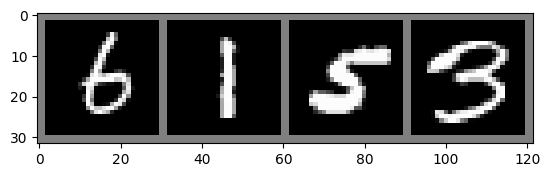

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
#dataiter = iter(trainloader)
images = fake_list[0]

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
images = real_list[0]

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력


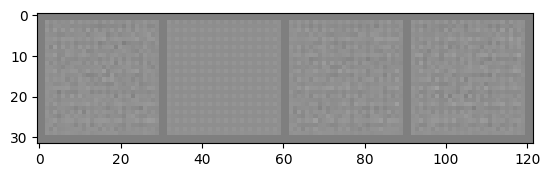

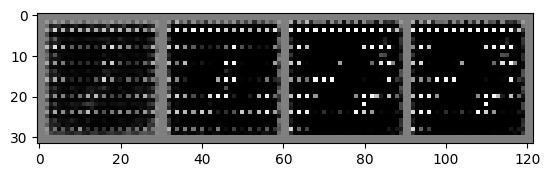

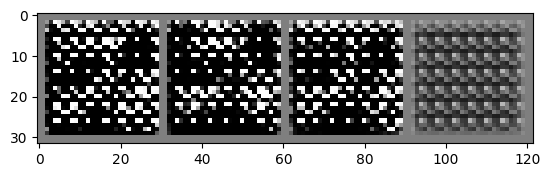

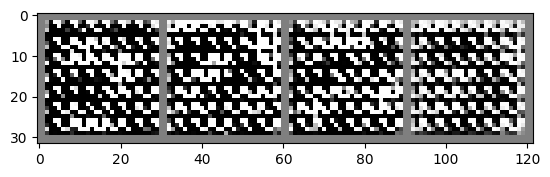

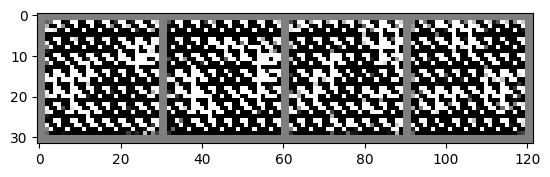

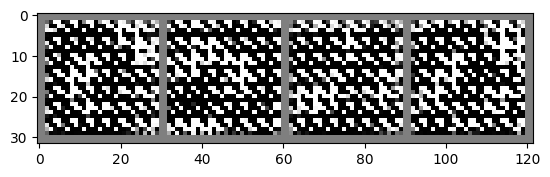

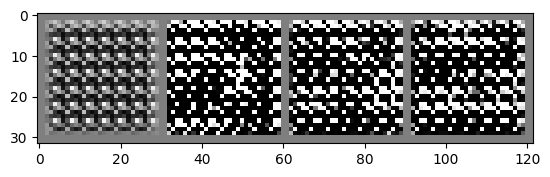

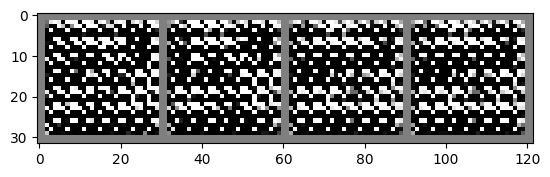

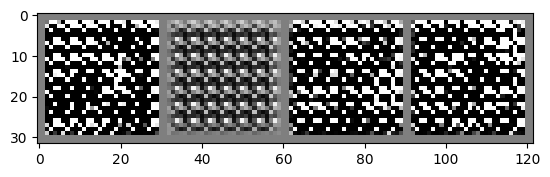

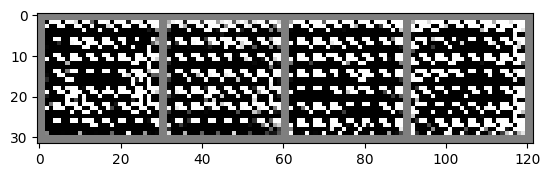

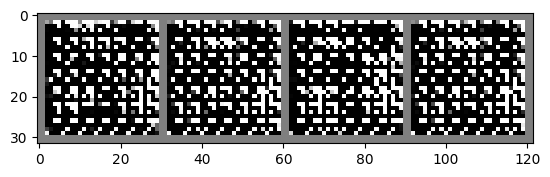

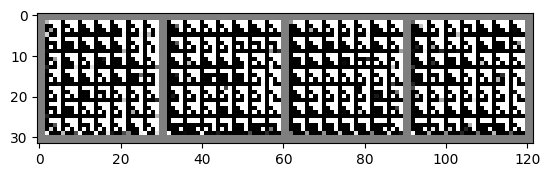

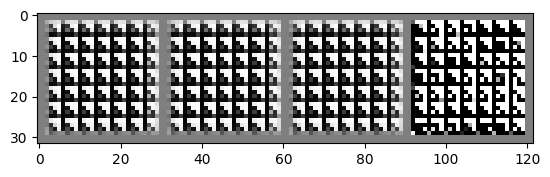

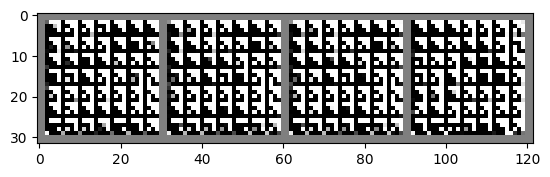

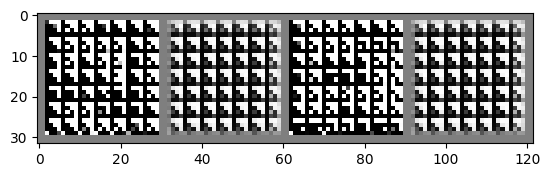

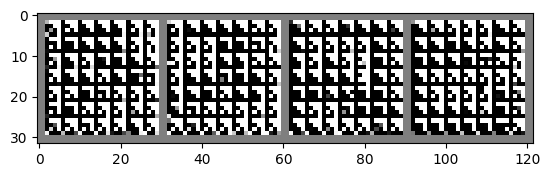

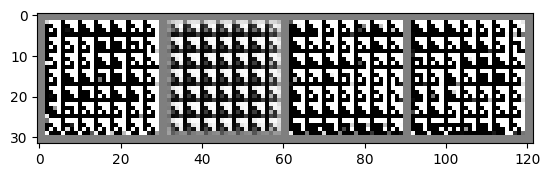

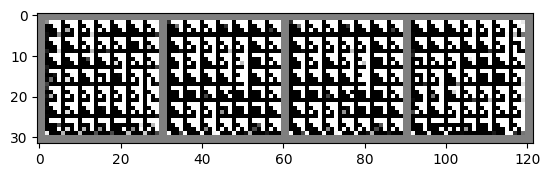

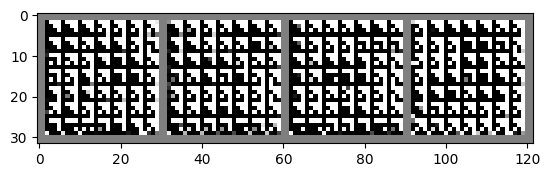

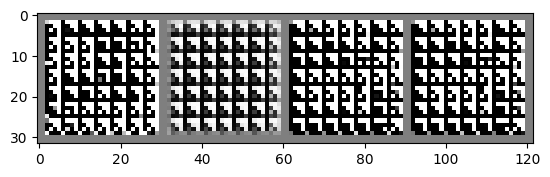

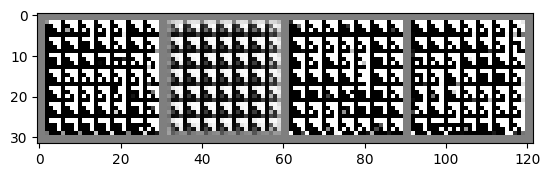

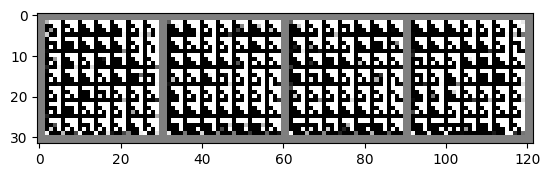

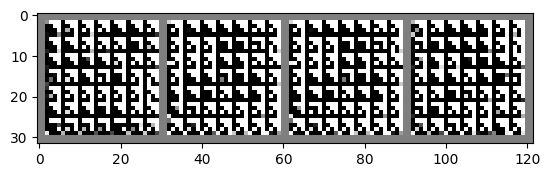

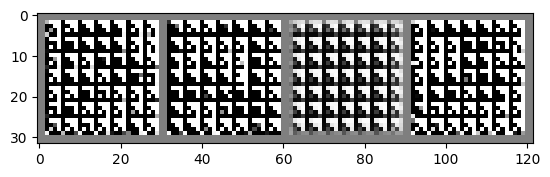

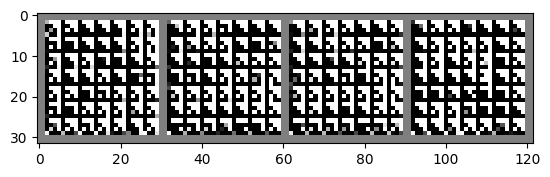

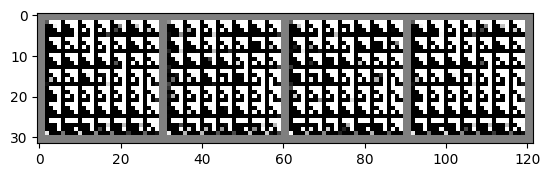

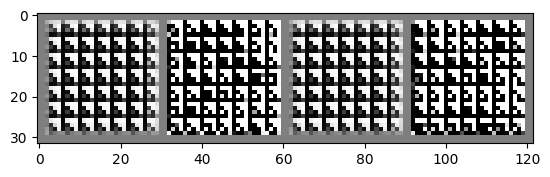

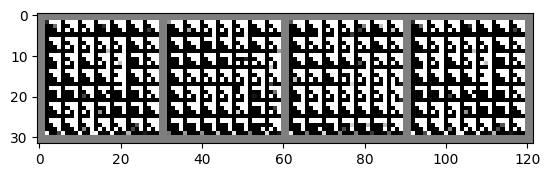

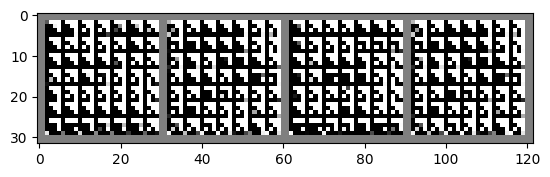

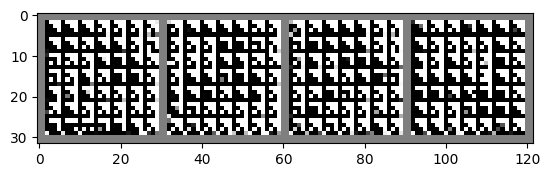

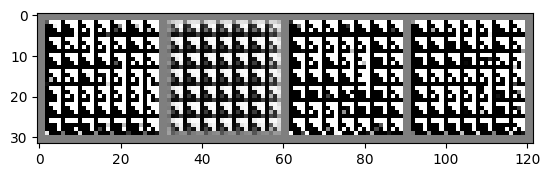

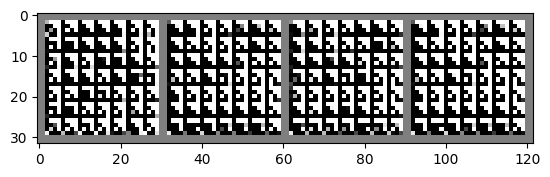

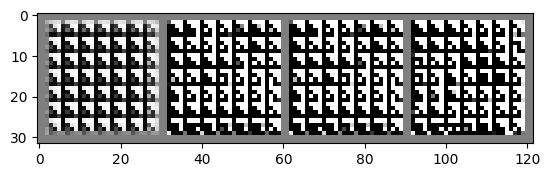

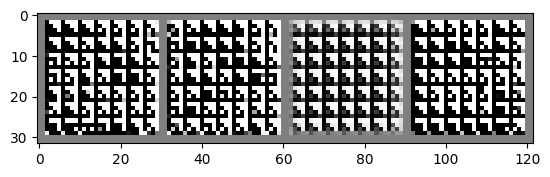

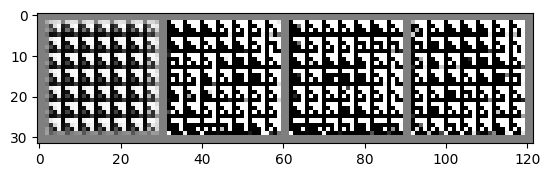

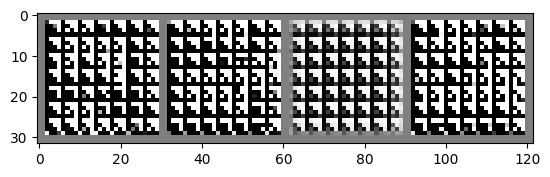

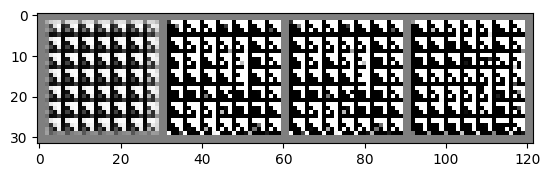

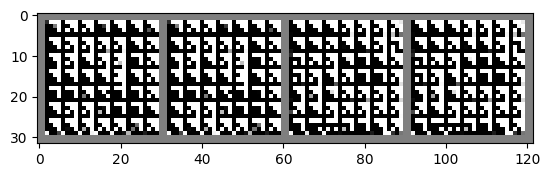

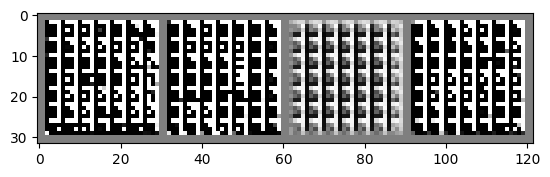

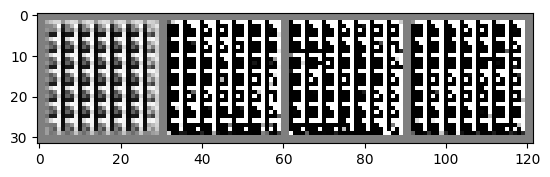

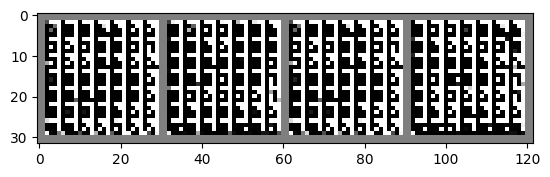

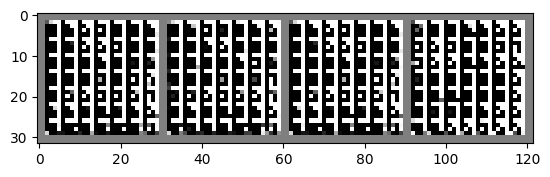

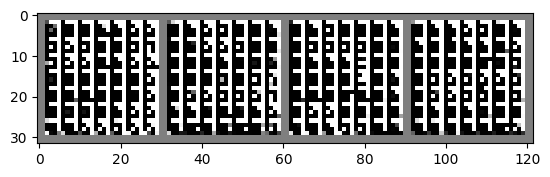

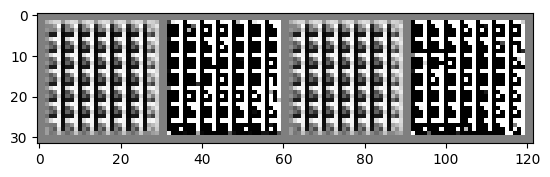

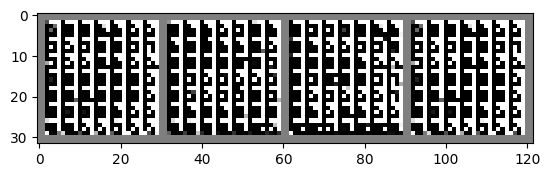

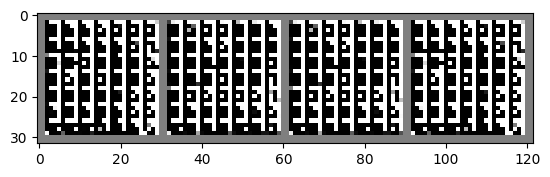

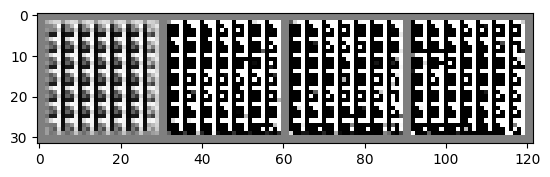

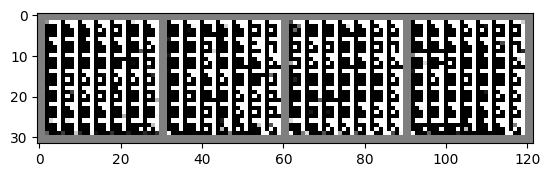

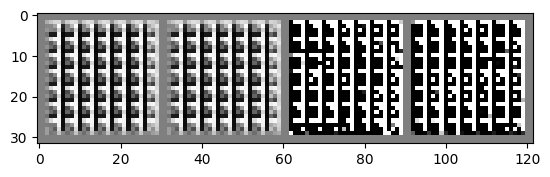

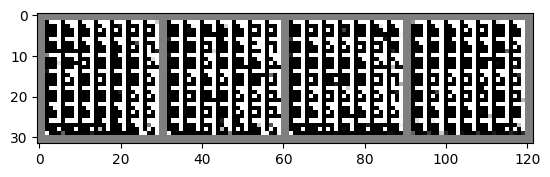

eight two   nine  six  


In [ ]:
images = fake_list

# 이미지 보여주기
for i in range(len(images)):
  imshow(torchvision.utils.make_grid(images[i]))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
image.shape

torch.Size([4, 1, 784])

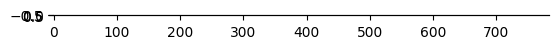

In [ ]:

imshow(torchvision.utils.make_grid(image))


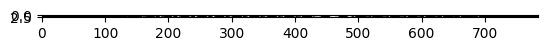

In [ ]:
plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
plt.show()

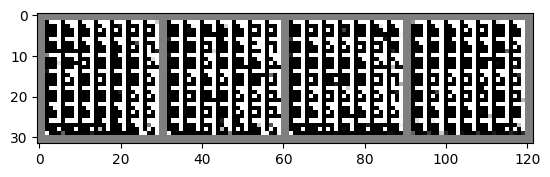

In [ ]:
output = disc(fake_list[-1].view(4, -1))
imshow(torchvision.utils.make_grid(fake_list[-1]))


In [ ]:
output

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
output = disc(real_list[-1].view(4, -1))
output

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

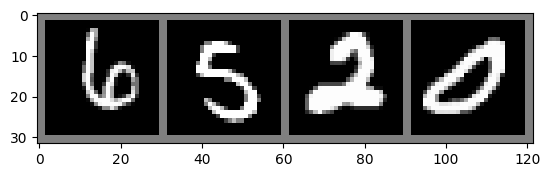

In [ ]:
imshow(torchvision.utils.make_grid(real_list[-1]))

In [ ]:
fake_list[-1][0]

tensor([[[-0.9998,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000,
           1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000,
           1.0000,  1.0000, -0.9998,  0.9999,  1.0000,  1.0000, -0.9984,
           1.0000,  1.0000,  1.0000, -0.9999,  0.9990,  1.0000,  0.6178],
         [-0.9997, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
           1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000,
           1.0000,  1.0000, -1.0000, -1.0000, -0.8250,  1.0000, -1.0000,
          -0.9998, -0.9950,  1.0000, -1.0000, -0.9878, -0.9999,  1.0000],
         [-1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
           1.0000, -1.0000, -0.9999, -1.0000,  1.0000, -1.0000,  1.0000,
          -1.0000,  1.0000, -1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
           1.0000, -0.9999,  1.0000, -1.0000,  1.0000, -0.9999,  0.9996],
         [-1.0000, -1.0000, -1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
           1.0000, -1.0000, -1.0000, -1.0000,  1

In [ ]:
real_list[-1][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -0.9686,  0.4039,  0.3176, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -0.1843,  0

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

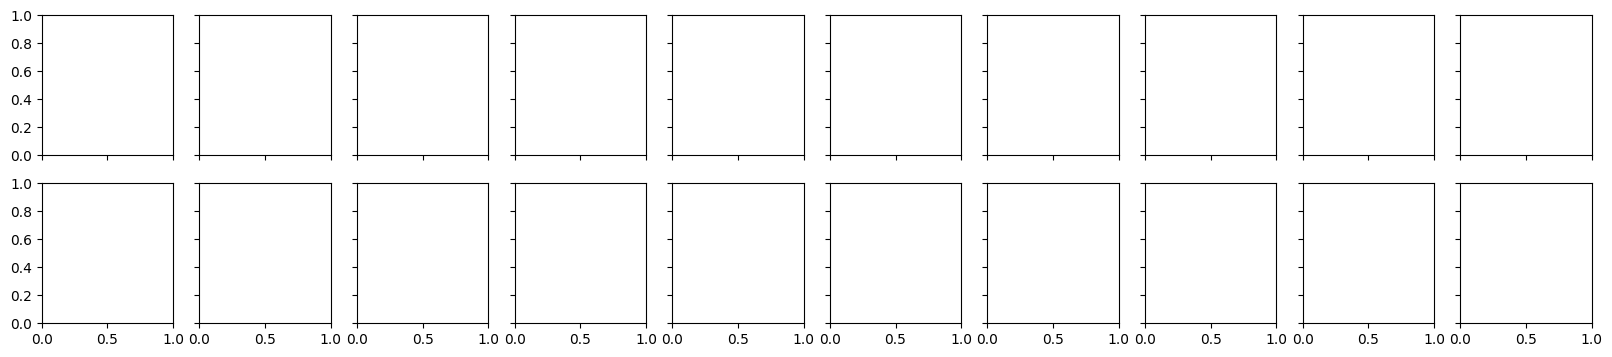

In [ ]:
# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([fake_list[-1], real_list[-1]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.cpu().numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
!pip install tensorboard

In [ ]:
!tensorboard --logdir=runs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs


In [ ]:
# 모델 초기화
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(model)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.view(-1, 28 * 28).to(device)

        # 순전파
        output = model(data)
        loss = criterion(output, data)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# 테스트 데이터셋에서 몇 가지 이미지를 복원하여 시각화
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, 28 * 28).to(device)
        output = model(data)
        output = output.view(-1, 1, 28, 28).cpu()
        break

# 원본 이미지와 복원된 이미지 시각화
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for images, row in zip([data.view(-1, 1, 28, 28).cpu(), output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()